<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

In [72]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [73]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "mean_squared_error",
      "goal": "minimize"   
    },
    "parameters": {
        "booster": {
            "values": ["gbtree","gblinear"]
        },
        "max_depth": {
            "values": [2, 3, 6, 7, 9, 12]
        },
        "n_estimators": {
            "values": [50, 100, 200]
        },
        "learning_rate": {
            "values": [0.01, 0.05, 0.02, 0.025]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        },
        "colsample_bytree": {
            "values": [0.3, 0.7]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="XGBoost_shot_2")

Create sweep with ID: npnwaw3w
Sweep URL: https://wandb.ai/malekkamoua/XGBoost_shot_2/sweeps/npnwaw3w


In [74]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	agg = concat(cols, axis=1)
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [75]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat

N_IN = 5
values = df[['% Silica Concentrate']].values

# Normalization
scaler = MinMaxScaler()
values = scaler.fit_transform(values)

# transform the time series data into supervised learning
new_data = series_to_supervised(values, n_in=N_IN)


In [76]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

In [ ]:
from numpy import asarray
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings(action='ignore', category=UserWarning)

# fit an xgboost model and make a one step prediction
def prediction_model(model, train, testX):
  train = asarray(train)
  trainX, trainy = train[:, :-1], train[:, -1]
  model.fit(trainX, trainy)
  yhat = model.predict(asarray([testX]))
  return yhat[0]

def forecast_validation(model, data, n_test):
  predictions = list()
  train, test = data[:-n_test, :], data[-n_test:, :]
  history = [x for x in train]
  for i in range(len(test)):
    testX, y_test = test[i, :-1], test[i, -1]
    y_pred = prediction_model(model, history, testX)
    predictions.append(y_pred)
    history.append(test[i])
    
    Inverse_y_pred = y_pred.reshape(-1,1)
    Inverse_y_pred = scaler.inverse_transform(Inverse_y_pred)

    Inverse_y_test = y_test.reshape(-1,1)
    Inverse_y_test = scaler.inverse_transform(Inverse_y_test)

    #print('actual = %.1f, predicted = %.1f' % (Inverse_y_test, Inverse_y_pred))

  mape, mae, rmse = forecast_accuracy(test[:, -1], predictions)

  return mape, mae, rmse, test[:, -1], predictions

In [78]:
from math import sqrt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE

def train():
  config_defaults = {
      'n_estimators': 200,
      "booster": "gbtree",
      "max_depth": 3,
      "learning_rate": 0.1,
    }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  model = XGBRegressor(n_estimators = config.n_estimators,
                      booster = config.booster,
                      max_depth = config.max_depth,
                      learning_rate = config.learning_rate,
                      objective ='reg:squarederror',
                      verbosity = 0)

  mape, mae, rmse, Inverse_y_test, Inverse_y_pred = forecast_validation(model, new_data, 12)
  plt.title("Predictions with %s [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (model.__class__.__name__, rmse, mape, mae) )

  wandb.log({"mean_squared_error": rmse})

In [ ]:
wandb.agent(sweep_id, train, count=25)

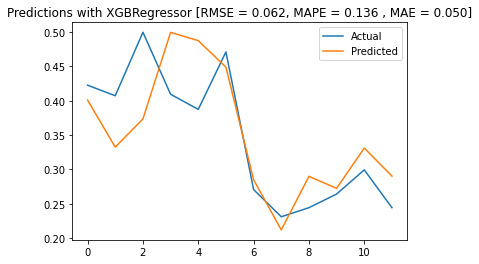

In [80]:
from matplotlib import pyplot

model = XGBRegressor(n_estimators = 200,
                     max_depth = 12,
                     subsample=0.5,
                     booster='gbtree',
                     learning_rate = 0.025,
                     colsample_bytree = 0.3,
                     objective ='reg:squarederror',
                     verbosity = 0)

mape, mae, rmse, Inverse_y_test, Inverse_y_pred = forecast_validation(model, new_data, 12)
plt.title("Predictions with %s [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (model.__class__.__name__, rmse, mape, mae) )

pyplot.plot(Inverse_y_test, label='Actual')
pyplot.plot(Inverse_y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [81]:
from sklearn.ensemble import RandomForestRegressor

sweep_rf_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "mean_squared_error",
      "goal": "minimize"   
    },
    "parameters": {
        "max_depth": {
            "values": [2, 3, 6, 7, 9, 12]
        },
        "n_estimators": {
            "values": [50, 100, 200]
        },
        
        "max_features": {
            "values": ['auto']
        },
        "min_samples_split": {
            "values": [3, 5, 7]
        }
    }
}

sweep_rf_id = wandb.sweep(sweep_rf_config, project="RandomForest_shot_2")

def train_rf():
  config_defaults = {
      'n_estimators': 200,
      "max_depth": 3,
      "max_features": 'auto',
      "min_samples_split": 3
    }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  model = RandomForestRegressor(n_estimators = config.n_estimators,
                                max_depth = config.max_depth,
                                min_samples_split = config.min_samples_split,
                                max_features= config.max_features)

  mape, mae, rmse, Inverse_y_test, Inverse_y_pred = forecast_validation(model, new_data, 12)
  plt.title("Predictions with %s [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (model.__class__.__name__, rmse, mape, mae) )

  wandb.log({"mean_squared_error": rmse})

Create sweep with ID: bswd44rz
Sweep URL: https://wandb.ai/malekkamoua/RandomForest_shot_2/sweeps/bswd44rz


In [ ]:
wandb.agent(sweep_rf_id, train_rf, count=25)

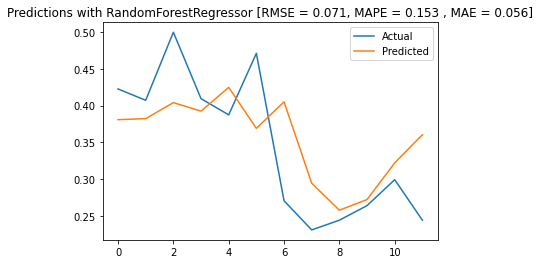

In [83]:
model = RandomForestRegressor(n_estimators=50,
                              max_features='auto',
                              min_samples_split = 5,
                              max_depth = 12)

mape, mae, rmse, Inverse_y_test, Inverse_y_pred = forecast_validation(model, new_data, 12)
plt.title("Predictions with %s [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (model.__class__.__name__, rmse, mape, mae) )

pyplot.plot(Inverse_y_test, label='Actual')
pyplot.plot(Inverse_y_pred, label='Predicted')
pyplot.legend()
pyplot.show()